# Modeling Preparation

## Imports and Some Dtype Conversions

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.svm import SVC  
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import plot_confusion_matrix

In [2]:
# import dataset
df = pd.read_csv('..\\data\\telecom_data.csv')

# Handle object types for international plan and voice mail plan
df.loc[df['international plan'] == 'no', 'international plan'] = 0
df.loc[df['international plan'] == 'yes', 'international plan'] = 1 

df.loc[df['voice mail plan'] == 'no', 'voice mail plan'] = 0
df.loc[df['voice mail plan']== 'yes', 'voice mail plan'] = 1

# Change churn to values: 1 (churned/True) 0 (no churn/False)
df.loc[df['churn'] == True, 'churn'] = 1
df.loc[df['churn'] == False, 'churn'] = 0

# going to create backup df and drop phone number from original df
# phone number could be used as unique id, but it doesn't seem necessary
df_backup = df.copy()
df = df.drop(['phone number'], axis=1)

# casting int values to churn, voice mail plan, and international plan cols
objs = ['international plan', 'voice mail plan', 'churn']

for o in objs:
    df = df.astype({o: int})
    
# dropping area code
df = df.drop(['area code'], axis=1)

# check df
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Handle international calls to bin them into categories easier.

In [3]:
# handle international calls to bin them into categories easier.
df['total intl calls'].value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total intl calls, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x18ade3e1fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x18ade3fb6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18ade3e1c40>],
 'medians': [<matplotlib.lines.Line2D at 0x18ade3fbd60>],
 'fliers': [<matplotlib.lines.Line2D at 0x18ade447100>],
 'means': []}

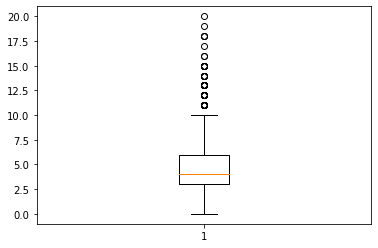

In [4]:
plt.boxplot(df['total intl calls'])

In [5]:
df['total intl calls'].describe()

count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total intl calls, dtype: float64

In [6]:
# range is 0-20 for international calls with most concentrated from 0-10
# I will bin into cats: low, moderate, and high with values <3, 3-6, and >6

list_tmp = []

for index, row in df.iterrows():
    if row['total intl calls'] < 3:
        list_tmp.append('low')
    elif row['total intl calls'] > 6:
        list_tmp.append('high')
    else:
        list_tmp.append('moderate')

df['total_intl_calls'] = list_tmp

df['total_intl_calls'].describe()

count         3333
unique           3
top       moderate
freq          2095
Name: total_intl_calls, dtype: object

## What would be the % chance of guessing correctly if the customer was assumed to not churn?

In [7]:
1-df.churn.mean()

0.8550855085508551

Guessing "not churned" for every customer would yield about an 85.5% chance of guessing correctly.

## Handle datatypes

Handle state and total_intl_calls object types. Turn these into integers for later modeling.

In [8]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA",
          "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
          "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX",
          "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [9]:
state_int = []
for i, row in df.iterrows():
    state_int.append(states.index(row['state']))

In [10]:
df['state_int'] = state_int

States in the dataset are alphabetically ordered such that Alabama is 0 and Wyoming is 50.

In [11]:
intl_calls_int = []
for i, row in df.iterrows():
    if row['total_intl_calls'] == 'low':
        intl_calls_int.append(0)
    elif row['total_intl_calls'] == 'moderate':
        intl_calls_int.append(1)
    else:
        intl_calls_int.append(2)

df['intl_calls_bins'] = intl_calls_int

In [12]:
cats = ['state_int', 'international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

## Feature Engineering: Totals for Charge, Minutes, and Calls

To reduce the number of variables and redundancies in the dataset, total calls, total charge, and total minutes will represent totals for each category. These new categories will not include international call data.

In [13]:
df['total_calls'] = df.apply(lambda x: x['total night calls'] + x['total day calls'] + x['total night calls'], 
                               axis=1)
df['total_charge']= df.apply(lambda x: x['total day charge'] + x['total eve charge'] + x['total night charge'],
                                             axis=1)
df['total_minutes'] = df.apply(lambda x: x['total day minutes'] + x['total eve minutes'] + x['total night minutes'],
                                             axis=1)

## Define X and y and Normalize the Data

In [14]:
y = df['churn']

# dropping # vmail messages because its distribution isn't normal
# drop redundancies now that there are total charge, minutes, and calls cols.
X = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state', 'total day minutes',
             'total day calls', 'total day charge', 'total eve minutes',
             'total eve calls', 'total eve charge', 'total night minutes',
             'total night calls', 'total night charge'], axis=1)

To clarify the new confusing column names ('x0_0' and so on), the following list is provided to retain what each column refers to:
* First 51 columns (x0_0-x0_50) refer to the states
* The next two columns (x1_0 & x1_1) refer to whether or not the customer has an international plan.
* Columns x2_0-x2_2 refer to the frequency (low, moderate, high) of international calls.
* Columns x3_0-x3_9 refer to how many calls to customer service the customer has completed.
* The last two columns indicate whether or not the customer has a voice mail plan.

## Train-test-split and SMOTE

In [20]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

# Fixing class imbalance with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

## OHE and Normalize

Avoiding data leakage by transforming after the split

In [21]:
# Seperate data into categorical for train and test sets
X_train_cats = X_train_resampled[cats]
X_test_cats = X_test[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    columns=ohe.get_feature_names()
)

ohe.fit(X_test_cats)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cats),
    index=X_test_cats.index,
    columns=ohe.get_feature_names()
)

# Scaling variables to work well with OHE data
X_train_numerics = X_train_resampled.drop(cats, axis=1)
X_test_numerics = X_test.drop(cats, axis=1)

scaler = MinMaxScaler()

scaler.fit(X_train_numerics)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numerics),
    index=X_train_numerics.index,
    columns=X_train_numerics.columns
)

scaler.fit(X_train_numerics)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numerics),
    index=X_test_numerics.index,
    columns=X_test_numerics.columns
)


# Concatenate
X_train_resampled = pd.DataFrame()
X_train_resampled = pd.concat([X_train_scaled, X_train_ohe], axis=1)

X_test = pd.DataFrame()
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

## Confusion Matrix Helper Function

In [24]:
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
            # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

# Baseline Model - Logistic Regression

## Fit data to model

In [25]:
# model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',
                            random_state=1)
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=1,
                   solver='liblinear')

## Evaluate

In [26]:
y_hat_train = logreg.predict(X_train_resampled)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    3341
1     901
Name: Residuals (counts), dtype: int64

0    0.7876
1    0.2124
Name: Residuals (proportions), dtype: float64


In [27]:
print(confusion_matrix(y_train_resampled, y_hat_train))  
print(classification_report(y_train_resampled, y_hat_train)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, y_hat_train)))

[[1653  468]
 [ 433 1688]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2121
           1       0.78      0.80      0.79      2121

    accuracy                           0.79      4242
   macro avg       0.79      0.79      0.79      4242
weighted avg       0.79      0.79      0.79      4242

The accuracy score is 0.7876001885902876


In [28]:
y_hat_test = logreg.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_test, y_hat_test))  
print(classification_report(y_test, y_hat_test)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_hat_test)))

0    635
1    199
Name: Residuals (counts), dtype: int64

0    0.761391
1    0.238609
Name: Residuals (proportions), dtype: float64
[[550 179]
 [ 20  85]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.85       729
           1       0.32      0.81      0.46       105

    accuracy                           0.76       834
   macro avg       0.64      0.78      0.65       834
weighted avg       0.88      0.76      0.80       834

The accuracy score is 0.7613908872901679


In [29]:
conf_matrix(y_test, y_hat_test)

{'TP': 85, 'TN': 550, 'FP': 179, 'FN': 20}

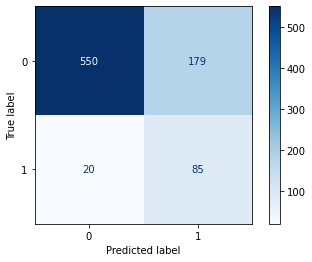

In [30]:
plot_confusion_matrix(logreg, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

Logistic Regression results:
* Both accuracy scores are below a the strategy of simply guessing "not churned" for every customer.
* It will be key to reduce the number of customers that are identified as retained but actually churned. Ideally everyone that can be identified as churning will be retained with some kind of strategy.

# Model 2 - RF

## Fit model

In [31]:
# random forest model
forest = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=13, random_state=1)

## Evaluate

In [34]:
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

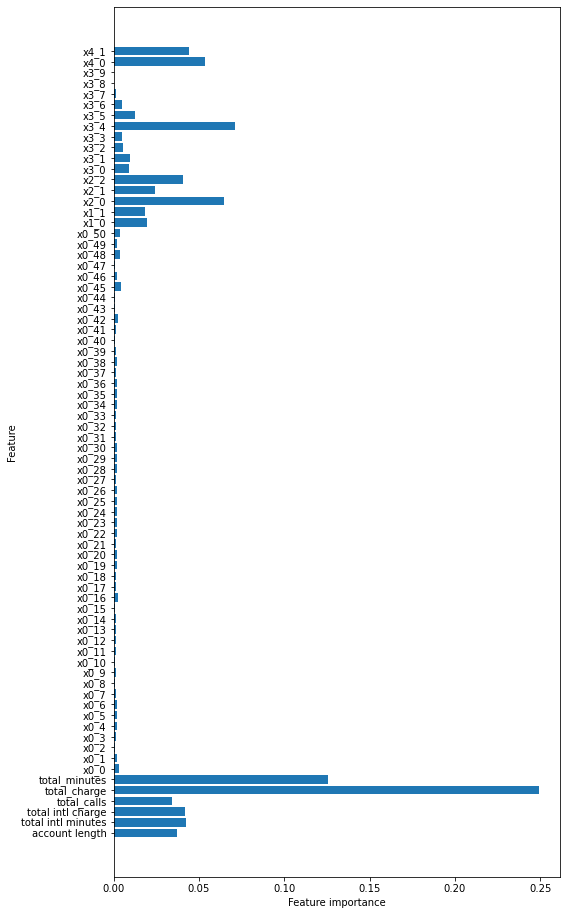

In [35]:
plot_feature_importances(forest)

In [36]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9125412541254125

In [37]:
# Testing Accuracy
forest.score(X_test, y_test)

0.907673860911271

In [38]:
y_hat_train = forest.predict(X_train_resampled)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_train_resampled, y_hat_train))  
print(classification_report(y_train_resampled, y_hat_train)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, y_hat_train)))

0    3871
1     371
Name: Residuals (counts), dtype: int64

0    0.912541
1    0.087459
Name: Residuals (proportions), dtype: float64
[[2039   82]
 [ 289 1832]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

The accuracy score is 0.9125412541254125


In [39]:
y_hat_test = forest.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_test, y_hat_test))  
print(classification_report(y_test, y_hat_test)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_hat_test)))

0    757
1     77
Name: Residuals (counts), dtype: int64

0    0.907674
1    0.092326
Name: Residuals (proportions), dtype: float64
[[666  63]
 [ 14  91]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       729
           1       0.59      0.87      0.70       105

    accuracy                           0.91       834
   macro avg       0.79      0.89      0.82       834
weighted avg       0.93      0.91      0.91       834

The accuracy score is 0.907673860911271


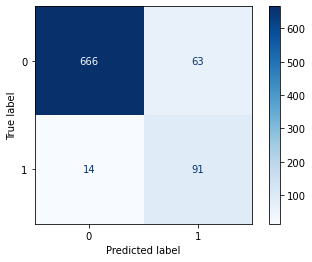

In [40]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

# Model 3 - Optimize RF Model

## Fit and use GridSearchCV to find best parameters

In [ ]:
# Using a pipeline to select for optimal parameters in the RF Classifier
pipe = Pipeline([('clf', RandomForestClassifier(random_state=1))])

grid_params = [{'clf__n_estimators': [100, 1000],
                'clf__criterion': ['gini', 'entropy'],
                'clf__max_depth': [None, 1, 5, 7, 11, 13, 17, 19],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [2, 3, 4, 5]
               }]

# grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=10)

# Fit using grid search
gs.fit(X_train_resampled, y_train_resampled)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

This GridSearchCV code took my machine about 1.5 hours to run.

In [41]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                max_depth=None, min_samples_leaf=2,
                                min_samples_split=5, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

## Evaluate

In [42]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9747760490334748

In [43]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9232613908872902

In [44]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test)) 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       729
           1       0.59      0.87      0.70       105

    accuracy                           0.91       834
   macro avg       0.79      0.89      0.82       834
weighted avg       0.93      0.91      0.91       834



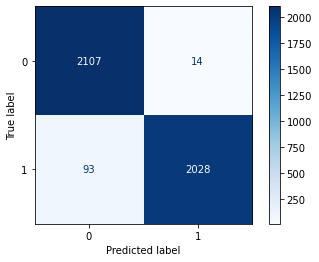

In [45]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

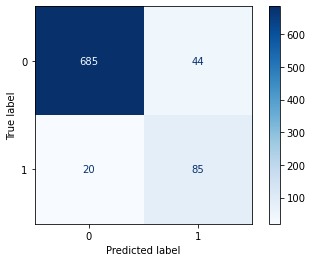

In [46]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

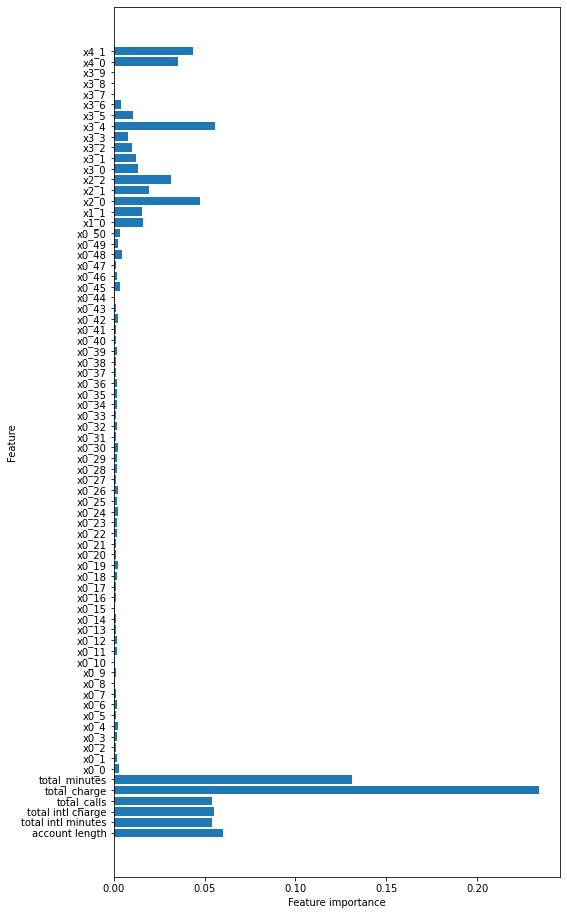

In [47]:
plot_feature_importances(forest)

# Model 4 - Optimize RF Model (2nd Attempt)

Attempting to reduce runtime by decreasing parameters a bit, but this code still does take a while to run.

To avoid overfitting in the RF Model, the following strategies will be utilized:
* Use less features (use something like 50% of total features for the max features parameter).
* Keep n_estimators large because the more trees there are, the less likely it is to overfit.

## Optimize RF Parameters and Fit

In [ ]:
# Using a pipeline to select for optimal parameters in the RF Classifier
pipe = Pipeline([('clf', RandomForestClassifier(random_state=1))])

grid_params = [{'clf__n_estimators': [100],
                'clf__criterion': ['entropy'],
                'clf__max_depth': [None, 1, 7, 15],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [2, 3, 4, 5],
                'clf__max_features': [37]     #this is 50% of total features
               }]

# grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=10)

# Fit using grid search
gs.fit(X_train_resampled, y_train_resampled)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

In [48]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                max_depth=None, min_samples_leaf=2,
                                min_samples_split=5, random_state=1,
                                max_features=37)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_features=37, min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

## Evaluate

In [49]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9962281942479962

In [50]:
# Testing Accuracy
forest.score(X_test, y_test)

0.935251798561151

In [51]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test)) 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       729
           1       0.59      0.87      0.70       105

    accuracy                           0.91       834
   macro avg       0.79      0.89      0.82       834
weighted avg       0.93      0.91      0.91       834



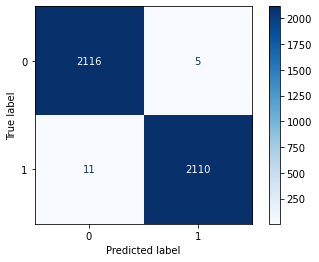

In [52]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

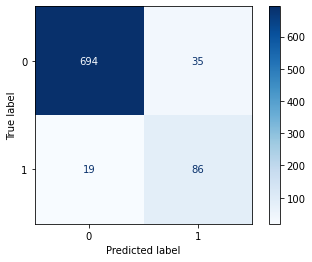

In [53]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

# Model 5 - SVM

Creating an SVM model to attempt to lower runtime expense found in the RF models.

## Fit Baseline SVM, and then optimize parameters

* Multiple types of kernel functions were tested.
* Poly and rbf kernels were the strongest, but poly seems to be slightly better.

In [54]:
svclassifier = SVC(kernel='poly', C=1)  
svclassifier.fit(X_train_resampled, y_train_resampled) 
y_pred = svclassifier.predict(X_test)

In [55]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[604 125]
 [ 18  87]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       729
           1       0.41      0.83      0.55       105

    accuracy                           0.83       834
   macro avg       0.69      0.83      0.72       834
weighted avg       0.90      0.83      0.85       834

The accuracy score is 0.8285371702637889


Optimize parameters to use in SVM

In [56]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='poly'), param_grid, cv=nfolds)
    grid_search.fit(X_train_resampled, y_train_resampled)
    grid_search.best_params_
    return grid_search.best_params_

In [57]:
svc_param_selection(X_train_resampled, y_train_resampled, 5)

{'C': 0.01, 'gamma': 1}

In [59]:
# best rbf params: C=10, gamma=1 with .861 accuracy on test set
# best poly params: C=1, gamma=1 with .887 accuracy on test set
svclassifier = SVC(kernel='poly', C=.01, gamma=1)  
svclassifier.fit(X_train_resampled, y_train_resampled) 
y_pred = svclassifier.predict(X_test)

## Evaluate

In [60]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[605 124]
 [ 15  90]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       729
           1       0.42      0.86      0.56       105

    accuracy                           0.83       834
   macro avg       0.70      0.84      0.73       834
weighted avg       0.91      0.83      0.86       834

The accuracy score is 0.8333333333333334


In [61]:
y_pred_train = svclassifier.predict(X_train_resampled)
accuracy_score(y_train_resampled, y_pred_train)

0.8689297501178689

In [62]:
print(confusion_matrix(y_train_resampled, y_pred_train))  
print(classification_report(y_train_resampled, y_pred_train))

[[1872  249]
 [ 307 1814]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2121
           1       0.88      0.86      0.87      2121

    accuracy                           0.87      4242
   macro avg       0.87      0.87      0.87      4242
weighted avg       0.87      0.87      0.87      4242



The accuracy score on the train set is about 12% higher than the test set, which suggests overfitting. The train set also predicted perfectly, which indicates complete overfitting to the training set. The test set evaluation shows many FNs and FPs. Overall, SVM does not seem like the best model for this problem.

# Model 6 - AdaBoost

The motivation for this model is to reduce runtime expense found in the RF model optimization processes.

## Instantiate Model and Fit

In [63]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)
adaboost_clf.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(random_state=42)

## Evaluate

In [64]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_resampled)
adaboost_test_preds = adaboost_clf.predict(X_test)

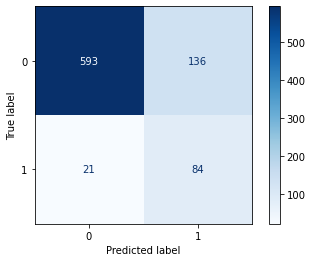

In [65]:
plot_confusion_matrix(adaboost_clf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [66]:
print(classification_report(y_test, adaboost_test_preds)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, adaboost_test_preds)))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       729
           1       0.38      0.80      0.52       105

    accuracy                           0.81       834
   macro avg       0.67      0.81      0.70       834
weighted avg       0.89      0.81      0.84       834

The accuracy score is 0.8117505995203836


In [67]:
print(classification_report(y_train_resampled, adaboost_train_preds))
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, adaboost_train_preds)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2121
           1       0.84      0.80      0.82      2121

    accuracy                           0.82      4242
   macro avg       0.82      0.82      0.82      4242
weighted avg       0.82      0.82      0.82      4242

The accuracy score is 0.8241395568128241


Comments on AdaBoost Model:
* It is very fast
* It completely overfit to the training set
* It has comparatively higher rate of FN (main column that is trying to be reduced) and FP in comparison to RF.
* It does not have as good of scoring (by any metric of comparison) to the RF models

## Tune Model with GridSearchCV and Run Again

In [68]:
gs = GridSearchCV(estimator=adaboost_clf,
                 param_grid={
                     'n_estimators': [25, 50, 100, 500],
                     'learning_rate': [.001, .01, .1, 1]
                 }, cv=5)

gs.fit(X_train_resampled, y_train_resampled)
gs.best_params_

{'learning_rate': 1, 'n_estimators': 100}

In [69]:
adaboost_clf = AdaBoostClassifier(learning_rate=1, n_estimators=100,
                                  random_state=42)
adaboost_clf.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)

In [70]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_resampled)
adaboost_test_preds = adaboost_clf.predict(X_test)

print(classification_report(y_train_resampled, adaboost_train_preds))
print(classification_report(y_test, adaboost_test_preds))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2121
           1       0.85      0.80      0.82      2121

    accuracy                           0.83      4242
   macro avg       0.83      0.83      0.83      4242
weighted avg       0.83      0.83      0.83      4242

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       729
           1       0.37      0.79      0.51       105

    accuracy                           0.81       834
   macro avg       0.67      0.80      0.69       834
weighted avg       0.89      0.81      0.83       834



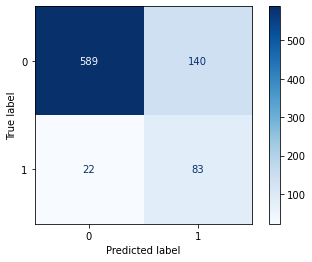

In [71]:
plot_confusion_matrix(adaboost_clf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

Significantly less FPs in this tuned model in comparison to the untuned AdaBoost model, but still does not perform nearly as well as RF

# RF Without State Column

The 'State' column is probably not particularly useful for SyriaTel, and none of the states seem to have super strong feature importance.

## Remove State Column and Prepare Dataset to Model

In [73]:
# Define X and y
y = df['churn']

# dropping # vmail messages because its distribution isn't normal
# drop redundancies now that there are total charge, minutes, and calls cols.
X = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state', 'total day minutes',
             'total day calls', 'total day charge', 'total eve minutes',
             'total eve calls', 'total eve charge', 'total night minutes',
             'total night calls', 'total night charge', 'state_int'], axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

# Fixing class imbalance with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

# define categorical columns
cats = ['international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

# Seperate data into categorical for train and test sets
X_train_cats = X_train_resampled[cats]
X_test_cats = X_test[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    columns=ohe.get_feature_names()
)

ohe.fit(X_test_cats)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cats),
    index=X_test_cats.index,
    columns=ohe.get_feature_names()
)

# Scaling variables to work well with OHE data
X_train_numerics = X_train_resampled.drop(cats, axis=1)
X_test_numerics = X_test.drop(cats, axis=1)

scaler = MinMaxScaler()

scaler.fit(X_train_numerics)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numerics),
    index=X_train_numerics.index,
    columns=X_train_numerics.columns
)

scaler.fit(X_train_numerics)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numerics),
    index=X_test_numerics.index,
    columns=X_test_numerics.columns
)


# Concatenate
X_train_resampled = pd.DataFrame()
X_train_resampled = pd.concat([X_train_scaled, X_train_ohe], axis=1)

X_test = pd.DataFrame()
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

## Fit Model

In [74]:
# random forest model
forest = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=13, random_state=1)

## Evaluate

In [75]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       729
           1       0.59      0.87      0.70       105

    accuracy                           0.91       834
   macro avg       0.79      0.89      0.82       834
weighted avg       0.93      0.91      0.91       834



In [76]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9566242338519566

In [77]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9292565947242206

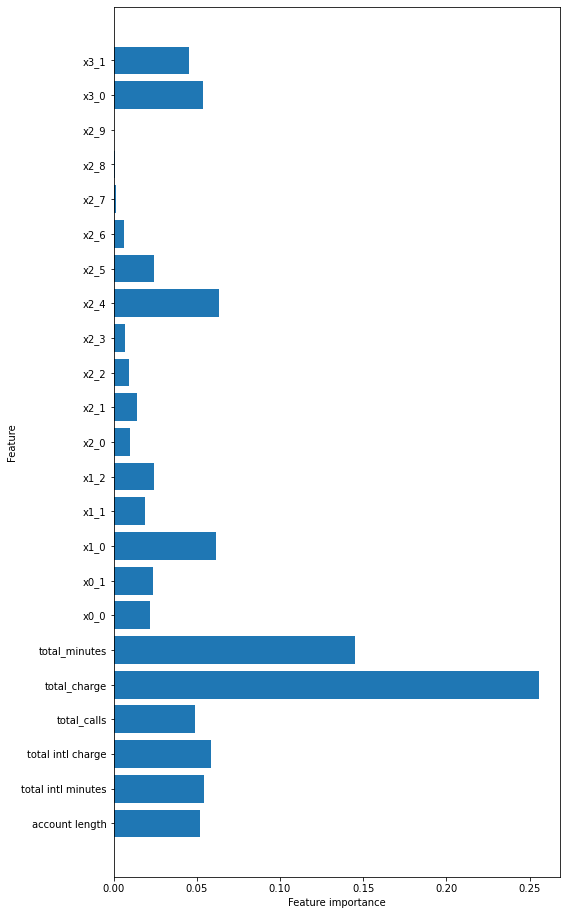

In [78]:
plot_feature_importances(forest)

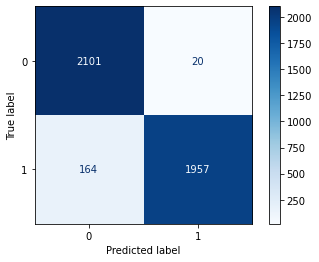

In [79]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

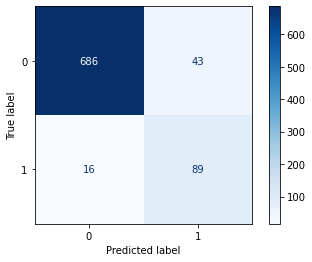

In [80]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

## Tune Model with GridSearchCV

In [ ]:
forest = RandomForestClassifier(random_state=1)

gs = GridSearchCV(estimator=forest,
                 param_grid={
                     'n_estimators': [100],     # 100 worked best previously
                     'criterion': ['entropy'],     # entropy worked best prev.
                     'max_depth': [None, 1, 7, 15],
                     'min_samples_split': [2, 5, 10],
                     'min_samples_leaf': [2, 3, 4, 5]
                 }, cv=10)

gs.fit(X_train_resampled, y_train_resampled)
gs.best_params_

Approximately 2.25 minute runtime for this GridSearchCV.

In [ ]:
# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

In [81]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy',
                                min_samples_leaf=2, min_samples_split=5,
                                max_depth=None, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

## Re-Evaluate

In [82]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       729
           1       0.59      0.87      0.70       105

    accuracy                           0.91       834
   macro avg       0.79      0.89      0.82       834
weighted avg       0.93      0.91      0.91       834



In [83]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9865629420084866

In [84]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9376498800959233

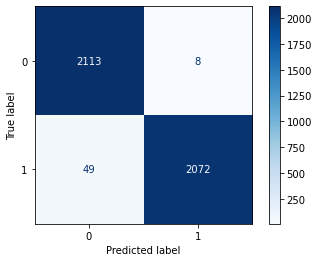

In [85]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

In [86]:
y_pred = forest.predict(X_test)
conf_matrix(y_test, y_pred)

{'TP': 88, 'TN': 694, 'FP': 35, 'FN': 17}

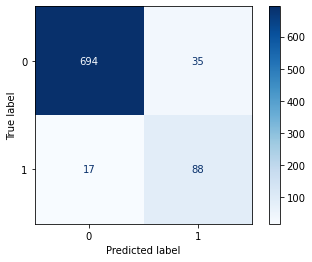

In [87]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

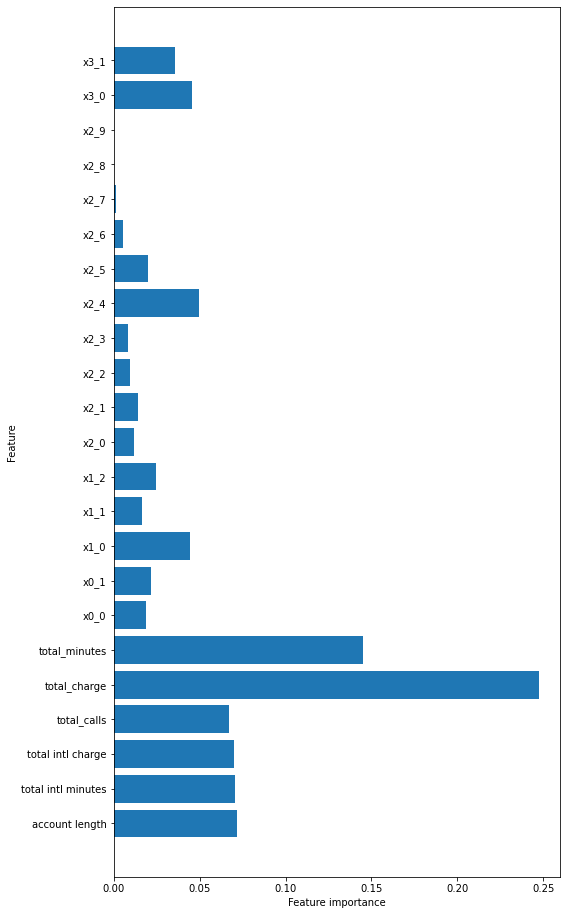

In [88]:
plot_feature_importances(forest)

In [ ]:
# try to visualize the tree
# adapted from: https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
# credits to Will Koehresen for the code above (link above)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(forest.estimators_[33], out_file='tree.dot', 
                feature_names = X.columns.to_list(),
                class_names = 'churn',
                rounded = True, proportion = False, 
                precision = 3, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Final Model Selection and Discussion

The goal of this project is to reduce customer churn rate for SyriaTel. This dataset is based in the US, so it is important for model results to extrapolate well to an application in Syria (where SyriaTel is based). 
To reduce customer churn rate, it is important to identify customers that are likely to churn, why these customers churn, and deploy a customer retention strategy on these customers.

Main evaluation metrics to use and the basis of justification for utilizing these metrics:
* The main goal is to implement retention strategies such as offering discounted rates, better plans, etc. to customers identified as likely to churn.
* Customers that are classified as churning by the model will be offered a retention strategy that will probably cost money to implement, but it can be justified by retaining the customer in the long term.
* Accuracy is important for minimizing total false negatives and false positives. 
* False negatives (customers identified as retained but are not actually retained) are important to minimize because these are customers that "fell through the cracks" and left without any attempt to save their business.
* False positives are important to minimize because these customers will potentially represent an unneeded cost because they will be offered one of the retention strategies, which costs the company money, even though they don't need incentive to stay with the company. This loss could be countered with some type of survey to identify dissatisfied customers, but it is important to decrease the amount of false positives.
* False negatives (customers identified as not churning but actually churned) should be penalized more because these customers do not have the potential to be retained with any particular strategy, they simply fall through the cracks. This cost is greater than a decent retention strategy because the retention strategy will signify an initial cost, but it will allow for the customer to be retained for a longer time.

Other justifications for model selection:
* The model must have potential to extrapolate from this dataset (from a US-based company) to the stakeholder (SyriaTel).
* It is ideal for the model to be deployed somewhat quickly so that customers can be classified as likely to churn or not at the end of various time periods, and so that customer retention strategies can be deployed quickly.

Retention Strategies:
* If the customer has an international plan, then offer a certain amount of months for free. The international plan in this dataset doesn't seem to do anything (check EDA notebook), and it probably wouldn't be of any cost for this particular company to offer international plans free for an extended period. But this idea is one strategy for retaining customers with international plans.
* Offer a discount for call charges. Total charge was an important feature in most models, so it will be useful to offer discounts to retain customers. 
* Create better customer service methods and offer solutions quickly to customers that call multiple times.
* Have an effective international plan.

Main Retention Strategy to Consider:
* Offer customers identified as likely to churn the option to have a discount such as 6 months at 50% off.

Items to consider:
* Assumptions have to be made in order to evaluate how effective the retention strategy will be.
* Assumption 1: average cost to acquire a new customer is around 300 dollars. Sources: https://www.forbes.com/sites/forbestechcouncil/2020/10/30/acquiring-subscribers-is-only-half-the-battle/https://www.entrepreneur.com/article/225415
* Average phone bill cost (in the US) for a single user: 70 dollars/month. Source: https://www.usmobile.com/blog/cut-cell-phone-bill/
* Assume that customers that leave the service will cost the company 370 dollars (cost of one month of service + cost to acquire new customer).
* For False Positive customers (model identifies customer as churning, but they do not churn), assume the cost to the company is (35 dollars* 6 months) = 210 dollars.
* For False Negative customers (model identifies as retained but they churn), assume the cost to the company is 370 dollars.
* For True Negative customers, assume the rate of retention (after offering the discount) is 80%. 
* The expected value for any True Negative customer is .8(-210+370) + .2(-370) = 54 dollars.

Metric to Use:
* A False Negative costs about 1.762 times as much as a False Positive. The metric will need to implement recognition of this discrepancy.
* 